In [1]:
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from pathlib import Path
from PIL import Image
from IPython.display import clear_output
#from scikitplot.metrics import plot_confusion_matrix, plot_roc
import tensorflow as tf

# From TensorFlow
from tensorflow.data.experimental import AUTOTUNE
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras
from keras.models import load_model, Model
from keras.initializers import glorot_uniform
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC, PrecisionAtRecall, SpecificityAtSensitivity, PrecisionAtRecall
from tensorflow.keras.losses import BinaryCrossentropy

# From scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score, auc

set_global_policy('mixed_float16')

C:\Users\ssre_\.conda\envs\py310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\ssre_\.conda\envs\py310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070, compute capability 8.9


# GPU Availability

In [2]:
# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {gpus}")
else:
    print("No GPU detected.")

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Constants and Hyperparameters

In [3]:
BATCH_SIZE = 64
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

IM_SIZE = 128

# Read the dataset
ROOT_DATASET_DIR = "../"
DATASET = os.path.join(ROOT_DATASET_DIR,"images")
MODELS = os.path.join(ROOT_DATASET_DIR,"models")

# Evaluation Functions

In [4]:
def partial_auc_score(y_actual, y_scores, tpr_threshold=0.80):
    max_fpr = 1 - tpr_threshold

    # create numpy arrays
    y_actual = np.asarray(y_actual)
    y_scores = np.asarray(y_scores)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_actual, y_scores)

    # Find the index where fpr exceeds max_fpr
    stop_index = np.searchsorted(fpr, max_fpr, side='right')

    if stop_index < len(fpr):
        # Interpolate to find the TPR at max_fpr
        fpr_interp_points = [fpr[stop_index - 1], fpr[stop_index]]
        tpr_interp_points = [tpr[stop_index - 1], tpr[stop_index]]
        tpr = np.append(tpr[:stop_index], np.interp(max_fpr, fpr_interp_points, tpr_interp_points))
        fpr = np.append(fpr[:stop_index], max_fpr)
    else:
        tpr = np.append(tpr, 1.0)
        fpr = np.append(fpr, max_fpr)

    # Calculate partial AUC
    partial_auc_value = auc(fpr, tpr)

    return partial_auc_value
    
# ploting model loss during training, created by Daniel: https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5
class plot_learning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def partial_auc_score_tf(y_true, y_pred):
    tpr_threshold = 0.80
    max_fpr = 1 - tpr_threshold

    # Convert true labels and predictions to float
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Calculate the ROC curve with TensorFlow
    #fpr, tpr, _ = tf.compat.v1.metrics.auc(y_true, y_pred, curve='ROC')
    fpr, tpr, _ = AUC(y_true, y_pred)
    #fpr, tpr, _ = tfa.metrics.roc_curve(y_true, y_pred)
    
    # Find the index where fpr exceeds max_fpr
    stop_index = tf.where(fpr <= max_fpr)[-1]

    # Gather points up to the stop index
    fpr = fpr[:stop_index + 1]
    tpr = tpr[:stop_index + 1]

    # Add the max_fpr point
    fpr = tf.concat([fpr, [max_fpr]], axis=0)
    tpr = tf.concat([tpr, [tpr[-1]]], axis=0)

    # Calculate the partial AUC
    partial_auc_value = tf.reduce_sum(tf.multiply(tf.diff(fpr), (tpr[1:] + tpr[:-1]) / 2))

    return partial_auc_value

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.show()

def find_roc_threshold_tpr(model, X, y, value_target):
    
    """
    This function calculates the threshold and false positive rate corresponding to a true positive rate of value_target (from 0 to 1).
    
    model                 # Trained model
    X                     # Feature dataset
    y                     # Target dataset
    value_target          # True positive rate value
    
    Returns:
    
    threshold             # Threshold value
    false_positive_rate   # False positive rate value
    """

    fpr, tpr, thr = roc_curve(y, model.predict_proba(X)[:,1])

    old_diff = 100000000
    for index, value in enumerate(tpr):
        new_diff = abs(value_target - value)
        if new_diff < old_diff:
            false_pos_rate = fpr[index]
            threshold = thr[index]
            old_diff = new_diff

    return threshold, false_pos_rate

# Image Preprocessing Functions

In [5]:
# Function for custom normalization
def custom_normalization(image):
    image = image / 255.0
    mean = tf.constant(MEAN, dtype=image.dtype)
    std = tf.constant(STD, dtype=image.dtype)
    image = (image - mean) / std  # Normalize each channel
    return image
    
# Parse and process images
def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IM_SIZE, IM_SIZE]) #, method=tf.image.ResizeMethod.LANCZOS3)
    image = custom_normalization(image)
    return image, label

# Generate dataset from file paths
def generate_dataset(file_paths, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# List image paths and labels
def get_image_paths_and_labels(directory):
    data_dir = Path(directory)    
    all_image_paths = list(data_dir.glob('*/*.jpg'))
    all_image_paths = [str(path) for path in all_image_paths]    
    all_labels = [0 if '\\0' in str(path) else 1 for path in all_image_paths]
    return all_image_paths, all_labels

# Create Dataset

In [6]:
# Test dataset
test_paths, test_labels = get_image_paths_and_labels(DATASET + '/test')
test_dataset = generate_dataset(test_paths, test_labels, BATCH_SIZE)

# Load Best Models

In [8]:
mr11 = load_model(os.path.join(MODELS,"rn152v2_nn256x128x64_lr0001_relu_batch64_epoch50_v1_best.keras"))
mr12 = load_model(os.path.join(MODELS,"rn152v2_nn256x128x64_lr0001_relu_batch64_epoch50_v1_final.keras"))
mr21 = load_model(os.path.join(MODELS,"rn152v2_nn256x128x64_lr0001_relu_batch64_epoch50_v2_best.keras"))
mr22 = load_model(os.path.join(MODELS,"rn152v2_nn256x128x64_lr0001_relu_batch64_epoch50_v2_final.keras"))

In [9]:
md11 = load_model(os.path.join(MODELS,"dn121_nn256x128x64_lr0001_relu_batch64_epoch50_v1_best.keras"))
md12 = load_model(os.path.join(MODELS,"dn121_nn256x128x64_lr0001_relu_batch64_epoch50_v1_final.keras"))
md21 = load_model(os.path.join(MODELS,"dn121_nn256x128x64_lr0001_relu_batch64_epoch50_v2_best.keras"))
md22 = load_model(os.path.join(MODELS,"dn121_nn256x128x64_lr0001_relu_batch64_epoch50_v2_final.keras"))

In [24]:
#m411 = load_model(os.path.join(MODELS,"rn152v2_nn256_lr0001_relu_batch64_epoch50_v41_best.keras"))

In [25]:
#m512 = load_model(os.path.join(MODELS,"dn121_nn256_lr0001_relu_batch64_epoch100_v51_final.keras"))

# Evaluation

In [26]:
y_p_mr11 = mr11.predict(test_dataset).reshape(-1)
y_p_mr12 = mr12.predict(test_dataset).reshape(-1)
y_p_mr21 = mr21.predict(test_dataset).reshape(-1)
y_p_mr22 = mr22.predict(test_dataset).reshape(-1)

927/927 [==============================] - 27s 29ms/step


In [27]:
y_p_md11 = md11.predict(test_dataset).reshape(-1)
y_p_md12 = md12.predict(test_dataset).reshape(-1)

927/927 [==============================] - 19s 21ms/step


In [28]:
y_p_md21 = md21.predict(test_dataset).reshape(-1)
y_p_md22 = md22.predict(test_dataset).reshape(-1)

927/927 [==============================] - 23s 23ms/step


In [29]:
#y_p_m342 = m342.predict(test_dataset).reshape(-1)

In [30]:
#y_p_m411 = m411.predict(test_dataset).reshape(-1)

In [31]:
#y_p_m512 = m512.predict(test_dataset).reshape(-1)

In [32]:
# Collect true labels
y_t = np.array(test_labels)

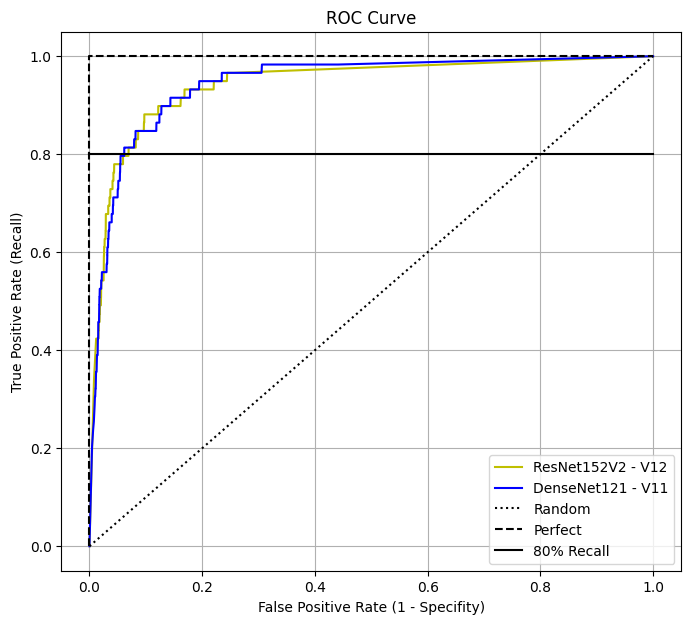

In [36]:
fprr11, tprr11, _ = roc_curve(y_t, y_p_mr11)
fprr12, tprr12, _ = roc_curve(y_t, y_p_mr12)
fprr21, tprr21, _ = roc_curve(y_t, y_p_mr21)
fprr22, tprr22, _ = roc_curve(y_t, y_p_mr22)
fprd11, tprd11, _ = roc_curve(y_t, y_p_md11)
fprd12, tprd12, _ = roc_curve(y_t, y_p_md12)
fprd21, tprd21, _ = roc_curve(y_t, y_p_md21)
fprd22, tprd22, _ = roc_curve(y_t, y_p_md22)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot()
#plt.plot(fprr11, tprr11, 'r-', label = 'ResNet152V2 - V11')
plt.plot(fprr12, tprr12, 'y-', label = 'ResNet152V2 - V12')
#plt.plot(fprr21, tprr21, 'g-', label = 'ResNet152V2 - V21')
#plt.plot(fprr22, tprr22, 'c-', label = 'ResNet152V2 - V22')
plt.plot(fprd11, tprd11, 'b-', label = 'DenseNet121 - V11')
#plt.plot(fprd12, tprd12, 'm-', label = 'DenseNet121 - V12')
#plt.plot(fprd21, tprd21, 'm-', label = 'DenseNet121 - V21')
#plt.plot(fprd22, tprd22, 'g-', label = 'DenseNet121 - V22')

plt.plot([0,1],[0,1],'k:',label='Random')
plt.plot([0,0,1,1],[0,1,1,1],'k--',label='Perfect')
plt.plot([0,1],[0.8,0.8],'k-',label='80% Recall')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specifity)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.show()

In [34]:
print('pAUC - Model ResNet152V2 V11: ', round(partial_auc_score(y_t, y_p_mr11), 4))
print('pAUC - Model ResNet152V2 V12: ', round(partial_auc_score(y_t, y_p_mr12), 4))
print('pAUC - Model ResNet152V2 V21: ', round(partial_auc_score(y_t, y_p_mr21), 4))
print('pAUC - Model ResNet152V2 V22: ', round(partial_auc_score(y_t, y_p_mr22), 4))
print('pAUC - Model DenseNet121 V11: ', round(partial_auc_score(y_t, y_p_md11), 4))
print('pAUC - Model DenseNet121 V12: ', round(partial_auc_score(y_t, y_p_md12), 4))
print('pAUC - Model DenseNet121 V21: ', round(partial_auc_score(y_t, y_p_md21), 4))
print('pAUC - Model DenseNet121 V22: ', round(partial_auc_score(y_t, y_p_md22), 4))

pAUC - Model ResNet152V2 V11:  0.157
pAUC - Model ResNet152V2 V12:  0.1584
pAUC - Model ResNet152V2 V21:  0.1521
pAUC - Model ResNet152V2 V22:  0.1533
pAUC - Model DenseNet121 V11:  0.156
pAUC - Model DenseNet121 V12:  0.1528
pAUC - Model DenseNet121 V21:  0.1528
pAUC - Model DenseNet121 V22:  0.1527


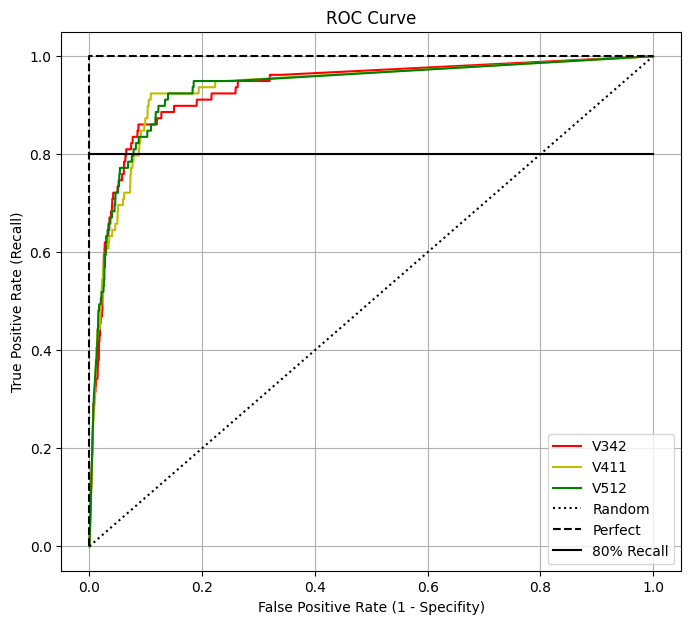

In [38]:
fpr11, tpr11, _ = roc_curve(y_t, y_p_m11)
fpr12, tpr12, _ = roc_curve(y_t, y_p_m12)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot()
plt.plot(fpr11, tpr11, 'r-', label = 'ResNet152V2 - V11')
plt.plot(fpr12, tpr12, 'y-', label = 'ResNet152V2 - V11')


plt.plot([0,1],[0,1],'k:',label='Random')
plt.plot([0,0,1,1],[0,1,1,1],'k--',label='Perfect')
plt.plot([0,1],[0.8,0.8],'k-',label='80% Recall')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specifity)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.show()

In [35]:
print('pAUC - Model 342: ', round(partial_auc_score(y_t, y_p_m342), 4))
print('pAUC - Model 411: ', round(partial_auc_score(y_t, y_p_m411), 4))
print('pAUC - Model 512: ', round(partial_auc_score(y_t, y_p_m512), 4))

342:  0.1544
411:  0.155
512:  0.1562
